## ART Black Box Attack

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from IPython.display import clear_output

from art import DATA_PATH
from art.classifiers import BlackBoxClassifier
from art.attacks import HopSkipJump
from art.utils import to_categorical
from art.utils import load_dataset, get_file, compute_accuracy

In [2]:
# Client for interacting with WML service:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

# For operating system commands:
import os
import json
from uuid import uuid4

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# TODO: Input your wml credentials in the json file
with open("wml_credentials_us.json") as file:
    wml_credentials = json.load(file)

wml = WatsonMachineLearningAPIClient(wml_credentials)

### Load data and connect to api

In [4]:
# connect to api
scoring_url = 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/7ba0bb68-7ddd-48c0-b63f-cb32e33c4dbc/deployments/088a8d85-9ee2-4097-8925-e1621ba87442/online'


In [5]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

### Make predictions

In [6]:
def predict(x):
    x = np.array(x)
    scoring_data = {'values': (np.reshape(x, (x.shape[0],784))).tolist()}
    predictions = wml.deployments.score(scoring_url, scoring_data)
    return to_categorical(predictions['values'], nb_classes=10)
    
classifier = BlackBoxClassifier(predict, x_train[0].shape, 10, clip_values=(0, 255))

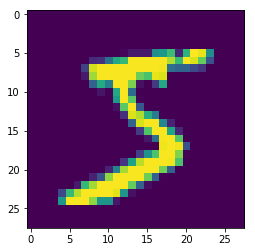

Prediction from API is: 5


In [7]:
target_image = x_train[0]
plt.imshow(np.reshape(target_image.astype(np.float32), (28, 28)))
plt.show(block=False)
print('Prediction from API is: ' + str(np.argmax(classifier.predict(x_train[:1]), axis=1)[0]))

### Generate black box HopSkipJump attack

Adversarial image at step 0. L2 error 8.14126717560526 and class label 3.


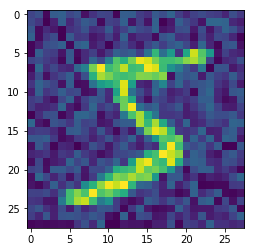

Adversarial image at step 10. L2 error 1.4863731301166878 and class label 3.


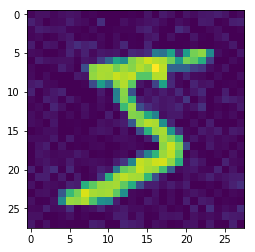

Adversarial image at step 20. L2 error 1.020744215199843 and class label 3.


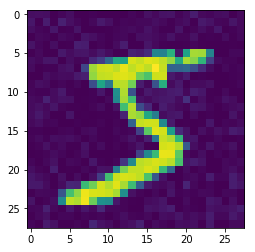

In [8]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None
for i in range(3):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv)
    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(np.reshape(x_adv[0].astype(np.float32), (28, 28)))
    plt.show(block=False)
    
    attack.max_iter = iter_step